In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 500
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))

X_train_all = load_all("X_train_all_90.pkl")
X_val_all = load_all("X_val_all_90.pkl")

In [4]:
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

y_train = load_y(path+"y_train.p")
y_val = load_y(path+"y_val.p")

In [5]:
print (X_train_all[0].shape)
print (X_train_all.shape)
print (X_train_all[0])
print (max(X_train_all[0]))
print (X_val_all[0].shape)
print (X_val_all.shape)
print (X_val_all[0])
print (max(X_val_all[0]))

(6000,)
(75000, 6000)
[  9.30213571 -30.65635962   2.24770751 ...   0.99585652   0.98546931
  -0.19068967]
17.55310737780931
(6000,)
(15000, 6000)
[ 1.99361009e+00 -2.76372462e+01  5.95588185e+00 ...  2.79753789e-01
 -1.65552558e-01  2.11403750e-02]
15.609482222685395


In [6]:
from sklearn import svm

In [7]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1],
     'gamma': [0.001, 0.01, 0.1, 1]
 }

In [8]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='sigmoid'), 
                      parameters, cv=3, iid=True, n_jobs=10, verbose=2)

In [9]:
stime=time.time()
model = gs_clf.fit(X_train_all, y_train)
print ("GridSearchTime:",time.time()-stime)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 269.5min
[Parallel(n_jobs=10)]: Done  48 out of  48 | elapsed: 471.2min finished


[LibSVM]GridSearchTime: 33509.7141251564


/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [10]:
model.best_score_

0.52796

In [11]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.1, 'gamma': 0.001}
C: 0.1
gamma: 0.001


In [12]:
pickle.dump(model,open("SVM_All_Sigmoid_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [13]:
X_test_all = load_all("X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [14]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='sigmoid',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)
print (preds_test_probs)

SampleSize: 100
[LibSVM]Train Time:0.40 sec
Validation Accuracy: 56.23%
Validation Time:8.32 sec
Test Accuracy: 54.93%
Test Time:8.24 sec
(0.3527811928811922, 0.116, 0.38466666666666666)
MRR: 0.3527811928811922
MRR Time:8.91 sec
SampleSize: 500
[LibSVM]Train Time:6.17 sec
Validation Accuracy: 55.89%
Validation Time:34.01 sec
Test Accuracy: 54.71%
Test Time:34.03 sec
(0.34894641654641584, 0.10866666666666666, 0.39466666666666667)
MRR: 0.34894641654641584
MRR Time:34.53 sec
SampleSize: 1000
[LibSVM]Train Time:24.84 sec
Validation Accuracy: 54.28%
Validation Time:62.10 sec
Test Accuracy: 54.42%
Test Time:62.10 sec
(0.3563176527176528, 0.114, 0.39066666666666666)
MRR: 0.3563176527176528
MRR Time:62.62 sec
SampleSize: 10000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:656.47 sec
Validation Accuracy: 50.28%
Validation Time:151.15 sec
Test Accuracy: 51.01%
Test Time:152.33 sec
(0.46636094276094314, 0.23066666666666666, 0.5913333333333334)
MRR: 0.46636094276094314
MRR Time:154.59 sec
SampleSize: 20000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:1338.10 sec
Validation Accuracy: 50.56%
Validation Time:144.95 sec
Test Accuracy: 51.31%
Test Time:144.93 sec
(0.45610788840788896, 0.21933333333333332, 0.568)
MRR: 0.45610788840788896
MRR Time:148.16 sec
SampleSize: 50000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:3459.93 sec
Validation Accuracy: 50.10%
Validation Time:171.94 sec
Test Accuracy: 50.39%
Test Time:171.91 sec
(0.37083703703703635, 0.13133333333333333, 0.416)
MRR: 0.37083703703703635
MRR Time:172.20 sec
SampleSize: 75000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:7300.70 sec
Validation Accuracy: 50.06%
Validation Time:243.10 sec
Test Accuracy: 50.53%
Test Time:253.24 sec
(0.4560392977392982, 0.216, 0.586)
MRR: 0.4560392977392982
MRR Time:243.18 sec
[0.5623, 0.5589, 0.5428, 0.5028, 0.5056, 0.501, 0.5006]
[0.5493, 0.5471, 0.5442, 0.5101, 0.5131, 0.5039, 0.5053]
[0.3527811928811922, 0.34894641654641584, 0.3563176527176528, 0.46636094276094314, 0.45610788840788896, 0.37083703703703635, 0.4560392977392982]
[0.116, 0.10866666666666666, 0.114, 0.23066666666666666, 0.21933333333333332, 0.13133333333333333, 0.216]
[0.38466666666666666, 0.39466666666666667, 0.39066666666666666, 0.5913333333333334, 0.568, 0.416, 0.586]
[[0.49181932 0.50818068]
 [0.49192358 0.50807642]
 [0.49202054 0.50797946]
 ...
 [0.49337251 0.50662749]
 [0.49337251 0.50662749]
 [0.49337251 0.50662749]]


In [17]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_Sigmoid_Accuracy.png")
    #plt.show()

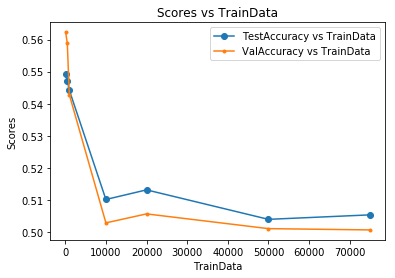

In [18]:
accuracyVisualization()

In [19]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_Sigmoid_Mrr.png")
    plt.show()

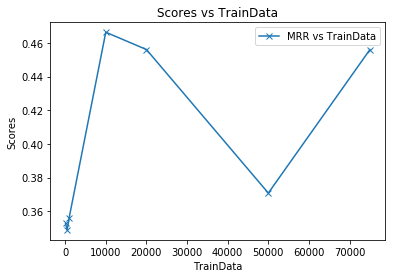

In [20]:
mrrVisualization()

In [21]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_All_Sigmoid_Precision.png")
    plt.show()

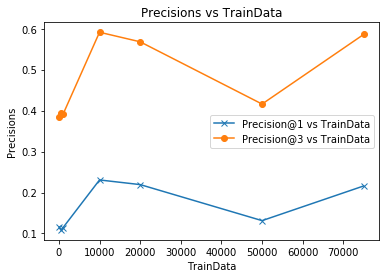

In [22]:
precisionVisualization()